**1. Импортируем нужные нам библиотеки**


In [238]:
# libs for data explorin`
import pandas as pd 
import numpy as np

# libs for vizualisation
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

# libs for data preprocessin`
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import (SelectKBest, f_classif, 
                                       chi2, mutual_info_classif, VarianceThreshold)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

from sklearn.model_selection import GroupShuffleSplit

# libs for models
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, 
                              GradientBoostingClassifier, VotingClassifier, StackingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.neural_network import MLPClassifier

from scipy.stats import uniform, randint

from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report

In [239]:
plt.style.use('seaborn-v0_8-darkgrid')

**1. Загружаем train датасет**

In [240]:
df_train = pd.read_csv(r'D:\Helper\MLBazyak\intensive2\data\train.csv', low_memory=False)
df_valid = pd.read_csv(r'D:\Helper\MLBazyak\intensive2\data\valid.csv', low_memory=False)
print(f'{df_train.shape}\n{df_valid.shape}')

(14456, 2666)
(3642, 2666)


**2. Обзор датасета**

In [241]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14456 entries, 0 to 14455
Columns: 2666 entries, report_date to col2663
dtypes: float64(2316), int64(3), object(347)
memory usage: 294.0+ MB


In [242]:
df_train.head()

,report_date,client_id,target,col1,col2,col3,col4,col5,col6,col7,...,col2654,col2655,col2656,col2657,col2658,col2659,col2660,col2661,col2662,col2663
0,2022-11-01,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
1,2022-11-01,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7616803.0,7616803.0,7616803.0,NaN,NaN,NaN,7616803.0,7616803.0,7616803.0,0.256261
2,2022-05-01,6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
3,2022-09-01,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.258682
4,2022-08-01,8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254164


**3. Базовая чистка и подготовка данных + baseline ~~бизнес~~ модель**

выбираю трешхолд для заполненности колонок у train датасета и запоминаю эти колонки для удаленяи таких же в valid

In [243]:
col2del = []
missing_procent = df_train.isna().mean()*100
for col, procent in missing_procent.items():
        if procent > 50:
            col2del.append(col) 

for col in df_train.loc[:, df_train.nunique() == 1].columns.tolist():
      col2del.append(col)
print(f'num of del columns: {len(col2del)}')

num of del columns: 2553


Функция для базовой предобработки датасета

In [244]:
def start_data_prep(df: pd.DataFrame, col2del: list = col2del) -> pd.DataFrame:
    '''performs basic processing of the dataset'''
    print('---------------------------------')
    print(f'start df shape: {df.shape}')
    df = df.select_dtypes(include=np.number)

    for col in col2del:
        if col in df.columns:
            del df[col]

    print(f'df shape after del`: {df.shape}')

    df = pd.DataFrame(
        SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(df), 
        columns=df.columns
    )
    print('---------------------------------')

    return df


Вывод информации по обработанным датасетам, разделение на Х и у

In [245]:
df_train_base = start_data_prep(df_train)
df_valid_base = start_data_prep(df_valid)

if set(df_train_base.columns) == set(df_valid_base.columns):
    print('all the columns match')
else:
    print('check ur code')

print('---------------------------------')

---------------------------------
start df shape: (14456, 2666)
df shape after del`: (14456, 180)
---------------------------------
---------------------------------
start df shape: (3642, 2666)
df shape after del`: (3642, 180)
---------------------------------
all the columns match
---------------------------------


In [246]:
X_train = df_train_base.drop('target', axis=1)
y_train = df_train_base['target']

groups = df_train_base['client_id']

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in gss.split(X_train, y_train, groups=groups):
    X_train, X_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train, y_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

assert X_train['client_id'].isin(X_test['client_id']).sum() == 0

X_valid = df_valid_base.drop('target', axis=1)
y_valid = df_valid_base['target']

Построение модели

In [247]:
# Обучаем модель на train
model = RandomForestClassifier(
    n_estimators=35,
    max_depth=None,
    min_samples_split=18,
    min_samples_leaf=7,
    max_features='sqrt',
    criterion='gini',
    class_weight='balanced',
    random_state=42
)
model.fit(X_train.drop('client_id', axis=1), y_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=7,
                       min_samples_split=18, n_estimators=35, random_state=42)

Вывод графиков

ROC-AUC on test data: 0.7319657215404147
Precission-Recall on test data: 0.06869008732969722
ROC-AUC on validation data: 0.804053538743136
Precission-Recall on validation data: 0.24578702010480083


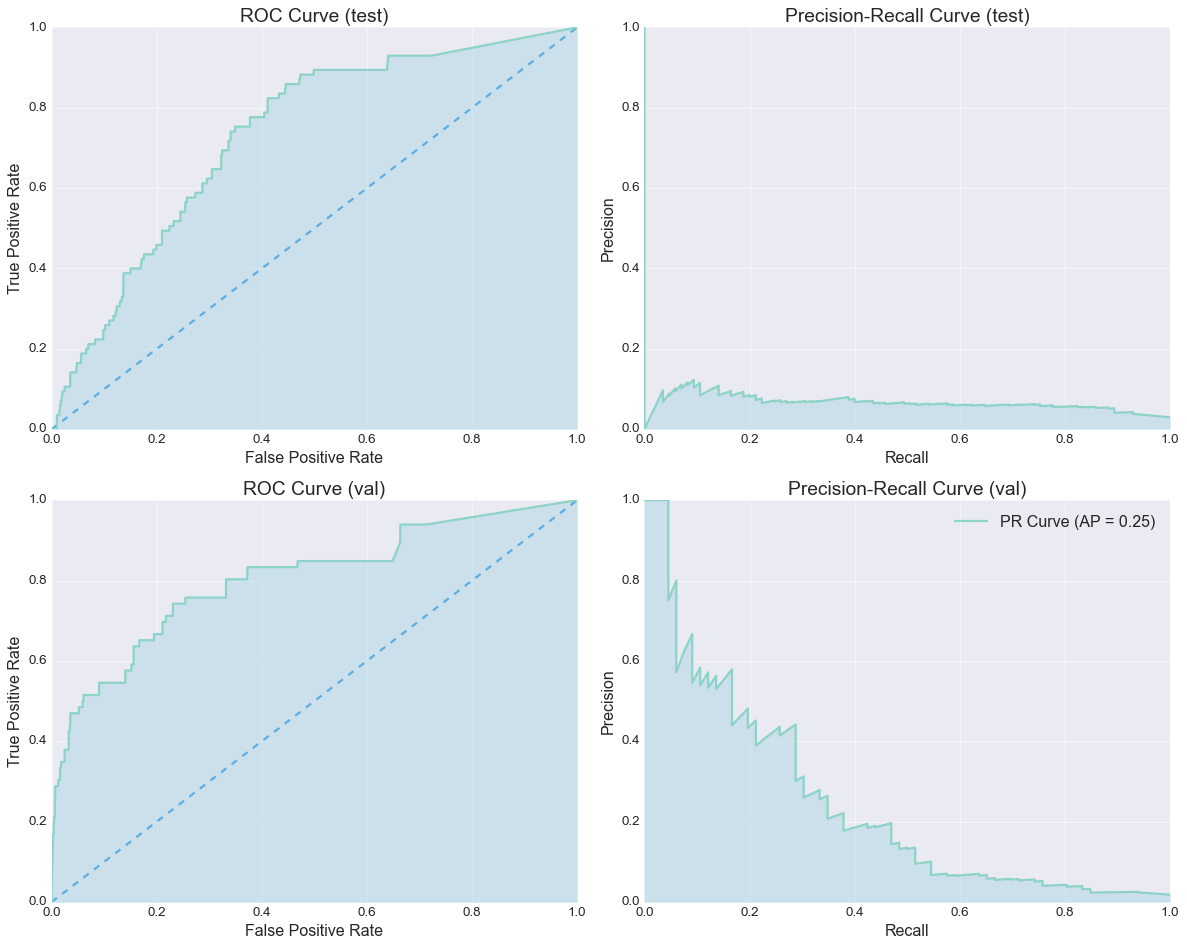

In [248]:
y_pred_proba_test = model.predict_proba(X_test.drop('client_id', axis=1))[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)
print(f"ROC-AUC on test data: {roc_auc_test}")
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)

precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_pred_proba_test)
average_precision_test = average_precision_score(y_test, y_pred_proba_test)
print(f'Precission-Recall on test data: {average_precision_test}')

y_pred_proba = model.predict_proba(X_valid.drop('client_id', axis=1))[:, 1]
roc_auc = roc_auc_score(y_valid, y_pred_proba)
print(f"ROC-AUC on validation data: {roc_auc}")
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_pred_proba)

precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_proba)
average_precision = average_precision_score(y_valid, y_pred_proba)
print(f'Precission-Recall on validation data: {average_precision}')

fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# ROC-curve test
axs[0,0].plot([0, 1], [0, 1], color='#5dade2', linestyle='--', label='Random Classifier (AUC = 0.5)')
axs[0,0].plot(fpr_test, tpr_test, label=f'Validation ROC curve: {roc_auc_test.round(2)}')
axs[0, 0].fill_between(fpr_test, tpr_test, color='lightblue', alpha=0.5)
axs[0,0].set_xlabel('False Positive Rate')
axs[0,0].set_ylabel('True Positive Rate')
axs[0,0].set_title('ROC Curve (test)')

# PR-curve test
axs[0,1].plot(recall_test, precision_test, label=f'PR Curve (AP = {average_precision_test.round(2)})')
axs[0,1].fill_between(recall_test, precision_test, color='lightblue', alpha=0.5)
axs[0,1].set_xlabel('Recall')
axs[0,1].set_ylabel('Precision')
axs[0,1].set_title('Precision-Recall Curve (test)')

# ROC-curve val
axs[1,0].plot([0, 1], [0, 1], color='#5dade2', linestyle='--', label='Random Classifier (AUC = 0.5)')
axs[1,0].plot(fpr_valid, tpr_valid, label=f'Validation ROC curve: {roc_auc.round(2)}')
axs[1,0].fill_between(fpr_valid, tpr_valid, color='lightblue', alpha=0.5)
axs[1,0].set_xlabel('False Positive Rate')
axs[1,0].set_ylabel('True Positive Rate')
axs[1,0].set_title('ROC Curve (val)')

# PR-curve val
axs[1,1].plot(recall, precision, label=f'PR Curve (AP = {average_precision.round(2)})')
axs[1,1].fill_between(recall, precision, color='lightblue', alpha=0.5)
axs[1,1].set_xlabel('Recall')
axs[1,1].set_ylabel('Precision')
axs[1,1].set_title('Precision-Recall Curve (val)')

plt.tight_layout()
plt.legend()
plt.show()

In [249]:
y_pred = model.predict(X_valid.drop('client_id', axis=1))

print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      3576
         1.0       0.54      0.11      0.18        66

    accuracy                           0.98      3642
   macro avg       0.76      0.55      0.58      3642
weighted avg       0.98      0.98      0.98      3642



Предварительные выводы: по ROC-AUC метрике результаты хорошие, но по PR метрике оставляют желать лучшего, 
это обосновывается несбалансированностью классов в target:

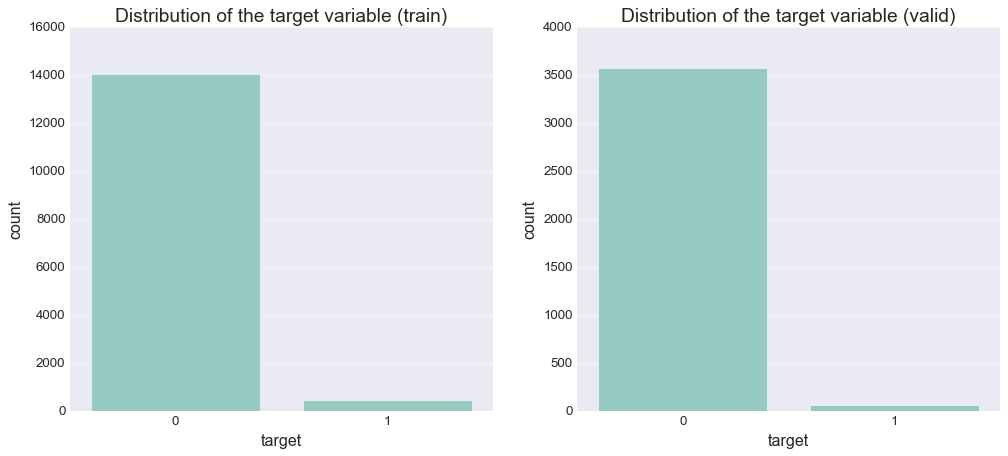

In [250]:
# distribution of the target variable
target_distribution_train = df_train['target'].value_counts()
target_distribution_val = df_valid['target'].value_counts()

# visualisation of distributions
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# train dist
sns.countplot(x='target', data=df_train, ax=axs[0])  #
axs[0].set_title('Distribution of the target variable (train)')

# valid dist
sns.countplot(x='target', data=df_valid, ax=axs[1])  
axs[1].set_title('Distribution of the target variable (valid)')

plt.show()

**4. Обработка данных**

Функция для обработки train датасета

In [251]:
def train_data_prep(df: pd.DataFrame, col2del: list = col2del):
    print('---------------------------------')
    print(f'Start df shape: {df.shape}')

    for col in col2del:
        if col in df.columns:
            del df[col]
            
    # ffill missin value from last report
    top_missing = (df.isna().mean()*100)\
        .sort_values(ascending=False).head(5)
    print("Top 5 most missing columns:", ", "\
        .join([f"{pct:.2f}%" for _, pct in top_missing.items()]))

    df = df.sort_values(by='report_date', ascending=False)
    df = df.groupby('client_id').apply(lambda group: group.ffill())
    df = df.reset_index(drop=True)
    
    top_missing = (df.isna().mean()*100)\
        .sort_values(ascending=False).head(5)
    print("Top 5 most missing columns:", ", "\
        .join([f"{pct:.2f}%" for _, pct in top_missing.items()]))

    print('---------------------------------')

    print(f'df shape "gilding" the dataset: {df.shape}')
    print('---------------------------------')
    # because the dataset has all the categorical attributes
    # are either date or uuid, delete them
    df = df.select_dtypes(include=np.number)

    print(f'df shape after deletin` useless cols: {df.shape}')

    print('---------------------------------')
    imputer = KNNImputer(n_neighbors=9, weights='uniform')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

    top_missing = (df.isna().mean()*100)\
        .sort_values(ascending=False).head(5)
    print("Top 5 most missing columns:", ", "\
        .join([f"{pct:.2f}%" for _, pct in top_missing.items()]))
    
    print('---------------------------------')
    # choosin` features with SelectKBest selector 
    selector = SelectKBest(score_func=f_classif, k=160) # Maximum Cross-Validation Accuracy: 0.9686 (k = 160)
                                                        # usin` f_classif for classification and 
    y = df['target']                                    # numeric data
    X_sel = selector.fit_transform(df,y)
    sel_cols = df.columns[selector.get_support()]
    df = pd.DataFrame(X_sel, columns=sel_cols)
    sel_cols = df.columns.tolist()

    print(f'df shape after feature selection: {df.shape}')
    print('---------------------------------')
    # normilizin` our data
    target = df['target']
    scaler = StandardScaler()
    df = pd.DataFrame(
        scaler.fit_transform(df.drop('target', axis=1)),
        columns=df.drop('target', axis=1).columns
        )
    df['target'] = target

    print('data is normalized...')
    print('---------------------------------')
    
    cl_id = df['client_id']
    y = df['target']
    X = df.drop('target', axis=1)
    pca = PCA(n_components=0.95)  
    X_pca = pca.fit_transform(X)
    X = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
    df = pd.concat([X, y], axis=1)
    df['client_id'] = cl_id
    print(type(pca))
    print(f'df shape after PCA: {df.shape}')

    # synthetic minority over-sampling technique
    # usin` SMOTE for over-samplin` // usin` ADASYN
    # adasyn = ADASYN(random_state=42)
    # X_adasyn, y_adasyn = adasyn.fit_resample(df.drop('target', axis=1), df['target'])
    # df = pd.DataFrame(X_adasyn, columns = df.drop('target',axis=1).columns)
    # df['target'] = y_adasyn
    
    
    # print(f'df shape after ADASYN: {df.shape}')
    # print(f'df shape after SMOTE: {df.shape}')
    print('---------------------------------')

    return df, sel_cols, scaler, pca

Функция для обработки valid датасета

In [252]:
def valid_data_prep(df: pd.DataFrame, sel_cols: list, scaler, pca, col2del: list = col2del):
    if 'target' not in df.columns:
        raise KeyError("Колонка 'target' отсутствует в валидационном датасете.")
    print('---------------------------------')
    print(f'Start df shape: {df.shape}')

    for col in col2del:
        if col in df.columns:
            del df[col]
            
    # ffill missin value from last report
    top_missing = (df.isna().mean()*100)\
        .sort_values(ascending=False).head(5)
    print("Top 5 most missing columns:", ", "\
        .join([f"{pct:.2f}%" for _, pct in top_missing.items()]))

    df = df.sort_values(by='report_date', ascending=False)
    df = df.groupby('client_id').apply(lambda group: group.ffill())
    df = df.reset_index(drop=True)
    
    top_missing = (df.isna().mean()*100)\
        .sort_values(ascending=False).head(5)
    print("Top 5 most missing columns:", ", "\
        .join([f"{pct:.2f}%" for _, pct in top_missing.items()]))

    print('---------------------------------')

    print(f'df shape "gilding" the dataset: {df.shape}')
    print('---------------------------------')
    # because the dataset has all the categorical attributes
    # are either date or uuid, delete them
    df = df.select_dtypes(include=np.number)

    print(f'df shape after deletin` useless cols: {df.shape}')

    print('---------------------------------')
    imputer = KNNImputer(n_neighbors=9, weights='uniform')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

    top_missing = (df.isna().mean()*100)\
        .sort_values(ascending=False).head(5)
    print("Top 5 most missing columns after KNNImputer:", ", "\
        .join([f"{pct:.2f}%" for _, pct in top_missing.items()]))
    
    print('---------------------------------')
    # takes only cols from train df features selection
    df = df[sel_cols]

    print(f'df shape after feature selection: {df.shape}')
    print('---------------------------------')
    # normilizin` our data
    target = df['target']

    df = pd.DataFrame(
        scaler.transform(df.drop('target', axis=1)),
        columns=df.drop('target', axis=1).columns
        )
    df['target'] = target

    print('data is normalized...')
    print('---------------------------------')

    cl_id = df['client_id']
    X_pca = pca.transform(df.drop('target', axis=1))
    X = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
    df = pd.concat([X, target], axis=1)
    df['client_id'] = cl_id
    print(f'df shape after PCA: {df.shape}')
    print('---------------------------------')

    return df

In [253]:
df_train_fin, sel_cols, scaler, pca = train_data_prep(df_train, col2del)
print(df_train_fin.shape)
print(len(sel_cols))

---------------------------------
Start df shape: (14456, 2666)
Top 5 most missing columns: 47.18%, 47.18%, 47.18%, 44.41%, 44.41%


C:\Users\alzot\AppData\Local\Temp\ipykernel_1508\580952789.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('client_id').apply(lambda group: group.ffill())


Top 5 most missing columns: 47.16%, 47.16%, 47.16%, 44.09%, 44.09%
---------------------------------
df shape "gilding" the dataset: (14456, 182)
---------------------------------
df shape after deletin` useless cols: (14456, 180)
---------------------------------
Top 5 most missing columns: 0.00%, 0.00%, 0.00%, 0.00%, 0.00%
---------------------------------
df shape after feature selection: (14456, 160)
---------------------------------
data is normalized...
---------------------------------
<class 'sklearn.decomposition._pca.PCA'>
df shape after PCA: (14456, 54)
---------------------------------
(14456, 54)
160


c:\Users\alzot\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


In [254]:
df_valid_fin = valid_data_prep(df_valid, sel_cols, scaler, pca, col2del)
df_valid_fin.shape

---------------------------------
Start df shape: (3642, 2666)
Top 5 most missing columns: 60.65%, 60.65%, 60.65%, 59.42%, 55.41%


C:\Users\alzot\AppData\Local\Temp\ipykernel_1508\3285370651.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('client_id').apply(lambda group: group.ffill())


Top 5 most missing columns: 60.57%, 60.57%, 60.57%, 59.34%, 55.33%
---------------------------------
df shape "gilding" the dataset: (3642, 182)
---------------------------------
df shape after deletin` useless cols: (3642, 180)
---------------------------------
Top 5 most missing columns after KNNImputer: 0.00%, 0.00%, 0.00%, 0.00%, 0.00%
---------------------------------
df shape after feature selection: (3642, 160)
---------------------------------
data is normalized...
---------------------------------
df shape after PCA: (3642, 54)
---------------------------------


(3642, 54)

Проверяем, одинаковые ли остались колонки в train и valid датасетах после работы с данными

In [255]:
if set(df_train_fin.columns) == set(df_valid_fin.columns):
    print('all the columns match')
else:
    print('check ur code')

print('---------------------------------')


all the columns match
---------------------------------


Как можно заметить, после преобразований датасета, на train наборе данных значения целевой колонки сбалансировались

Text(0.5, 1.0, 'distribution of the target var (after data preprocessin`)')

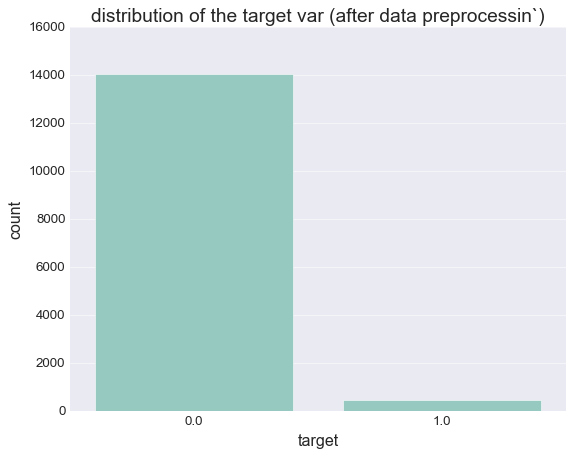

In [256]:
sns.countplot(x='target', data = df_train_fin)
plt.title('distribution of the target var (after data preprocessin`)')

**5. Построение модели**

Начнем с такой же модели RandomForestClassifier, какую использовали для baseline модели

In [257]:
X_train_full = df_train_fin.drop('target', axis=1)
y_train_full = df_train_fin['target']
groups = df_train_fin['client_id']  

# usin` GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# split data
for train_idx, test_idx in gss.split(X_train_full, y_train_full, groups=groups):
    X_train, X_test = X_train_full.iloc[train_idx], X_train_full.iloc[test_idx]
    y_train, y_test = y_train_full.iloc[train_idx], y_train_full.iloc[test_idx]

# check that client_ids do not overlap
assert X_train['client_id'].isin(X_test['client_id']).sum() == 0

Назначаем valid переменные

In [258]:
X_valid = df_valid_fin.drop('target', axis=1)
y_valid = df_valid_fin['target']

Функция для вывода нужных метрик и графиков у модели

In [259]:
def evaluate_model(model, X_test, y_test, X_valid, y_valid, title):
    # Предсказания на тестовой и валидационной выборках
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    y_pred_proba_valid = model.predict_proba(X_valid)[:, 1]

    # Метрики для тестовой выборки
    roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_proba_test)
    average_precision_test = average_precision_score(y_test, y_pred_proba_test)

    # Метрики для валидационной выборки
    roc_auc_valid = roc_auc_score(y_valid, y_pred_proba_valid)
    precision_valid, recall_valid, _ = precision_recall_curve(y_valid, y_pred_proba_valid)
    average_precision_valid = average_precision_score(y_valid, y_pred_proba_valid)

    # Вывод метрик
    print(f"ROC-AUC on test data: {roc_auc_test}")
    print(f"Precision-Recall on test data: {average_precision_test}")
    print(f"ROC-AUC on validation data: {roc_auc_valid}")
    print(f"Precision-Recall on validation data: {average_precision_valid}")

    # Построение графиков
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))

    # ROC-curve test
    axs[0, 0].plot([0, 1], [0, 1], color='#5dade2', linestyle='--', label='Random Classifier (AUC = 0.5)')
    axs[0, 0].plot(roc_curve(y_test, y_pred_proba_test)[0], roc_curve(y_test, y_pred_proba_test)[1], label=f'Test ROC curve: {roc_auc_test.round(2)}')
    axs[0, 0].fill_between(roc_curve(y_test, y_pred_proba_test)[0], roc_curve(y_test, y_pred_proba_test)[1], color='lightblue', alpha=0.5)
    axs[0, 0].set_xlabel('False Positive Rate')
    axs[0, 0].set_ylabel('True Positive Rate')
    axs[0, 0].set_title('ROC Curve (test)')

    # PR-curve test
    axs[0, 1].plot(recall_test, precision_test, label=f'PR Curve (AP = {average_precision_test.round(2)})')
    axs[0, 1].fill_between(recall_test, precision_test, color='lightblue', alpha=0.5)
    axs[0, 1].set_xlabel('Recall')
    axs[0, 1].set_ylabel('Precision')
    axs[0, 1].set_title('Precision-Recall Curve (test)')

    # ROC-curve val
    axs[1, 0].plot([0, 1], [0, 1], color='#5dade2', linestyle='--', label='Random Classifier (AUC = 0.5)')
    axs[1, 0].plot(roc_curve(y_valid, y_pred_proba_valid)[0], roc_curve(y_valid, y_pred_proba_valid)[1], label=f'Validation ROC curve: {roc_auc_valid.round(2)}')
    axs[1, 0].fill_between(roc_curve(y_valid, y_pred_proba_valid)[0], roc_curve(y_valid, y_pred_proba_valid)[1], color='lightblue', alpha=0.5)
    axs[1, 0].set_xlabel('False Positive Rate')
    axs[1, 0].set_ylabel('True Positive Rate')
    axs[1, 0].set_title('ROC Curve (val)')

    # PR-curve val
    axs[1, 1].plot(recall_valid, precision_valid, label=f'PR Curve (AP = {average_precision_valid.round(2)})')
    axs[1, 1].fill_between(recall_valid, precision_valid, color='lightblue', alpha=0.5)
    axs[1, 1].set_xlabel('Recall')
    axs[1, 1].set_ylabel('Precision')
    axs[1, 1].set_title('Precision-Recall Curve (val)')

    # Общий заголовок
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.legend()
    plt.show()

Определяем модель

In [260]:
# train the model on the train
rfc = RandomForestClassifier( 
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    criterion='gini',
    class_weight='balanced',
    random_state=42
)
rfc.fit(X_train.drop('client_id', axis=1), y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

Вывод графиков и метрик

ROC-AUC on test data: 0.8316842996191283
Precision-Recall on test data: 0.16989607155774963
ROC-AUC on validation data: 0.7582812182224934
Precision-Recall on validation data: 0.20036783653952886


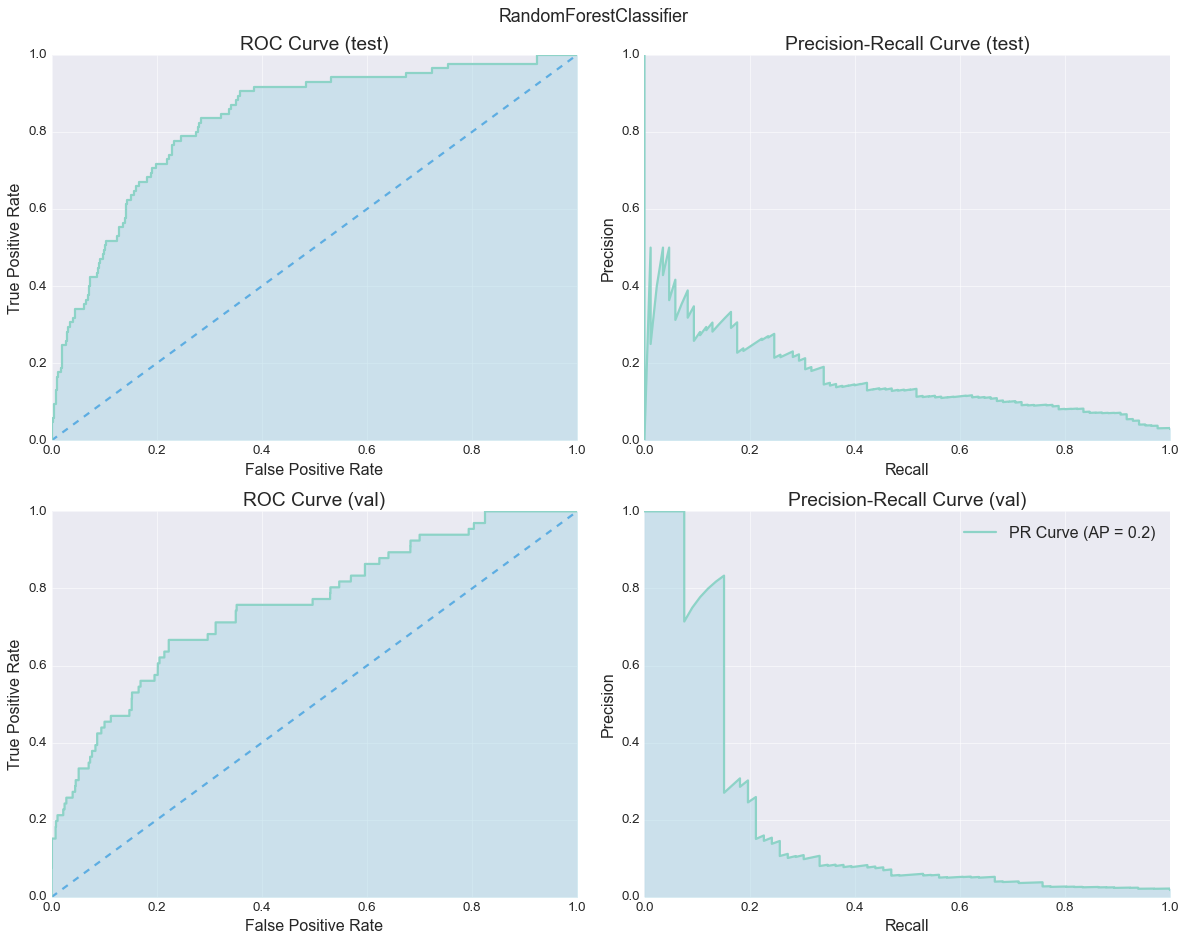

In [261]:
evaluate_model(rfc, X_test.drop('client_id', axis=1), y_test, X_valid.drop('client_id', axis=1), y_valid, 'RandomForestClassifier')

Список моделей для проверок

In [262]:
models_list = [
    LGBMClassifier(
        num_leaves=40,
        learning_rate=0.01,
        n_estimators=300,
        random_state=42,
        reg_lambda=1.0
    ),
    LogisticRegression(random_state=42),
    HistGradientBoostingClassifier(random_state=42),
    ExtraTreesClassifier(random_state=42),
    KNeighborsClassifier(n_neighbors=9, weights='uniform', metric='correlation'),
    XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),
    GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ),
    RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        min_samples_split=2,
        random_state=42
    ),
    MLPClassifier(
        hidden_layer_sizes=(100,),
        activation='relu',
        alpha=0.0001,
        random_state=42
    )
]

In [263]:
for model in models_list:
    model.fit(X_train, y_train)

    y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)
    print(f"ROC-AUC on test data: {roc_auc_test}")
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)

    precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_pred_proba_test)
    average_precision_test = average_precision_score(y_test, y_pred_proba_test)
    print(f'Precission-Recall on test data: {average_precision_test}')

    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    roc_auc = roc_auc_score(y_valid, y_pred_proba)
    print(f"ROC-AUC on validation data: {roc_auc}")
    fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_pred_proba)

    precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_proba)
    average_precision = average_precision_score(y_valid, y_pred_proba)
    print(f'Precission-Recall on validation data: {average_precision}')
    print('---------------------------------')

[LightGBM] [Info] Number of positive: 351, number of negative: 11240
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13515
[LightGBM] [Info] Number of data points in the train set: 11591, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030282 -> initscore=-3.466448
[LightGBM] [Info] Start training from score -3.466448
ROC-AUC on test data: 0.8306495979686839
Precission-Recall on test data: 0.17562957589678818
ROC-AUC on validation data: 0.7903722628974308
Precission-Recall on validation data: 0.16733708561455612
---------------------------------
ROC-AUC on test data: 0.7992848074481591
Precission-Recall on test data: 0.10514580565713039
ROC-AUC on validation data: 0.6955121686665311
Precission-Recall on validation data: 0.048841343697779364
---------------------------------
ROC-AUC on test data: 0.8205268726195515
P

XGBClassifier

ROC-AUC on test data: 0.8340457046127804
Precision-Recall on test data: 0.19291877378314146
ROC-AUC on validation data: 0.8116610738255035
Precision-Recall on validation data: 0.17473376733313456


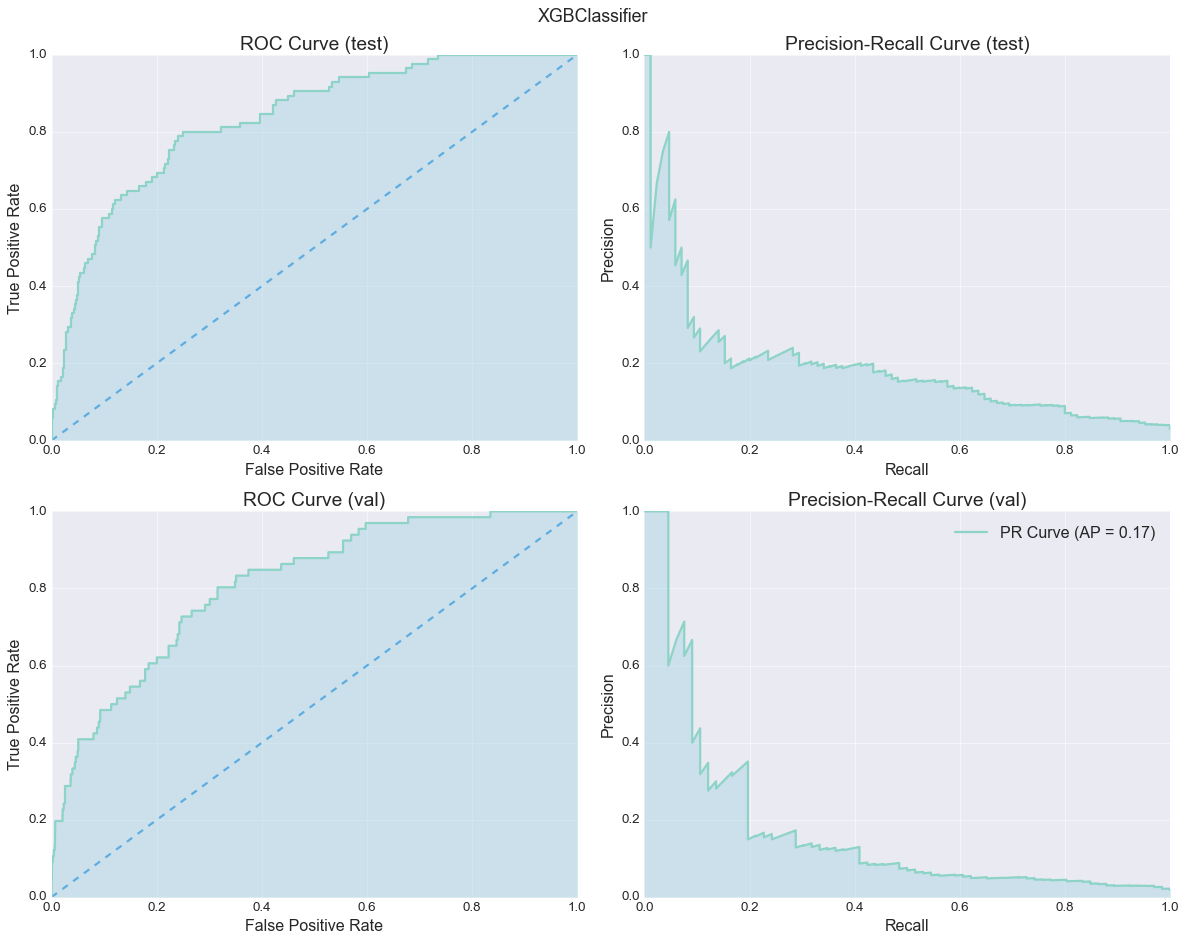

In [264]:
xgbc = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgbc.fit(X_train, y_train)

# Оценка модели
evaluate_model(xgbc, X_test, y_test, X_valid, y_valid, 'XGBClassifier')

HistGradientBoostingClassifier

ROC-AUC on test data: 0.8231273804485824
Precision-Recall on test data: 0.1889932708694139
ROC-AUC on validation data: 0.7891562436444988
Precision-Recall on validation data: 0.15865902094995263


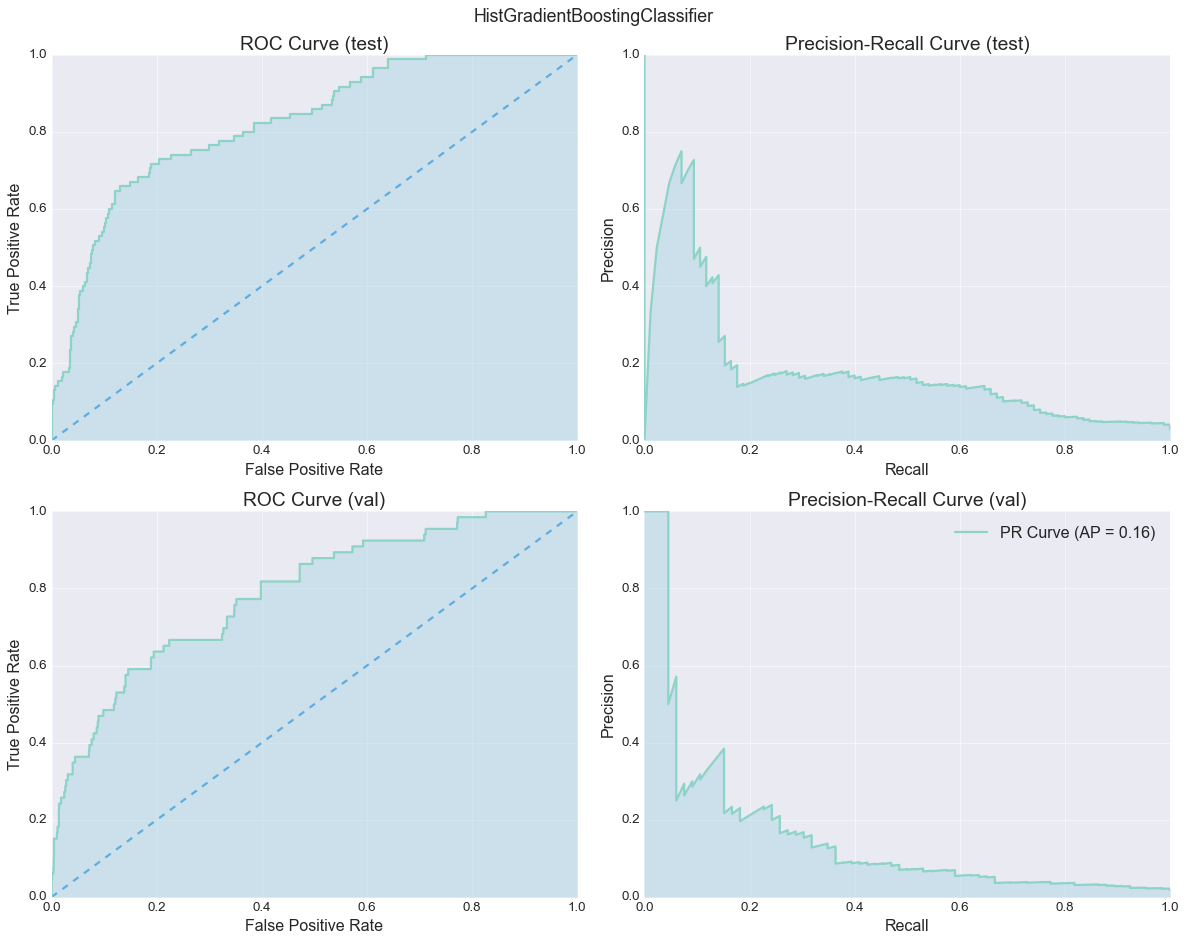

In [265]:
hgbc = HistGradientBoostingClassifier(
    learning_rate=0.01,
    max_iter=1000,
    max_depth=10,
    min_samples_leaf=50,
    l2_regularization=1.0,
    max_bins=255,
    class_weight='balanced',
    random_state=42,
    early_stopping=True
)
hgbc.fit(X_train, y_train)

evaluate_model(hgbc, X_test, y_test, X_valid, y_valid, 'HistGradientBoostingClassifier')

LGBMClassifier

[LightGBM] [Info] Number of positive: 351, number of negative: 11240
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13515
[LightGBM] [Info] Number of data points in the train set: 11591, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030282 -> initscore=-3.466448
[LightGBM] [Info] Start training from score -3.466448
ROC-AUC on test data: 0.8231273804485824
Precision-Recall on test data: 0.1889932708694139
ROC-AUC on validation data: 0.7891562436444988
Precision-Recall on validation data: 0.15865902094995263


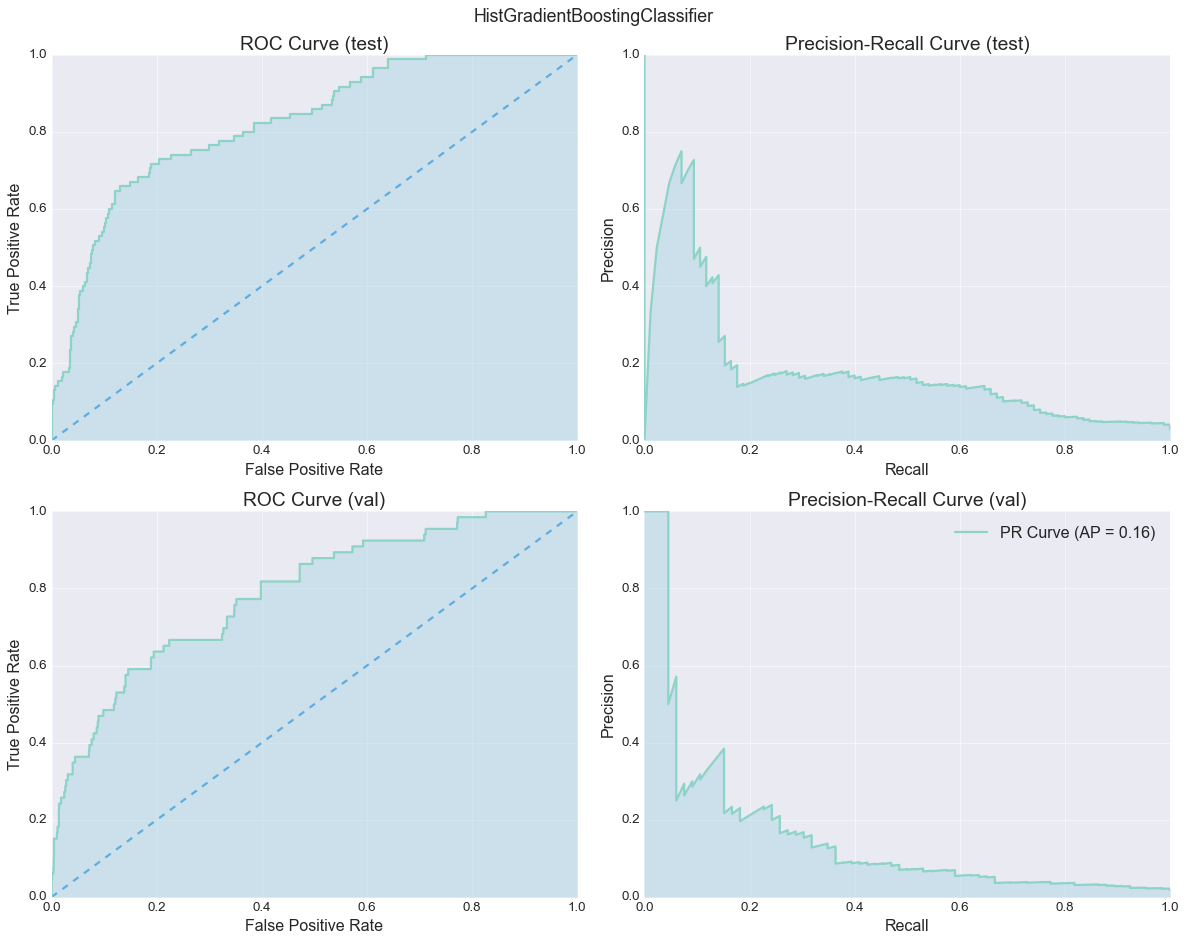

In [266]:
lgbmc = LGBMClassifier(
        num_leaves=40,
        learning_rate=0.01,
        n_estimators=300,
        random_state=42,
        reg_lambda=1.0
    )
lgbmc.fit(X_train, y_train)

evaluate_model(hgbc, X_test, y_test, X_valid, y_valid, 'HistGradientBoostingClassifier')

GradientBoostingClassifier

ROC-AUC on test data: 0.8185146000846382
Precision-Recall on test data: 0.1761680180205237
ROC-AUC on validation data: 0.7605882652023592
Precision-Recall on validation data: 0.06778624418289171


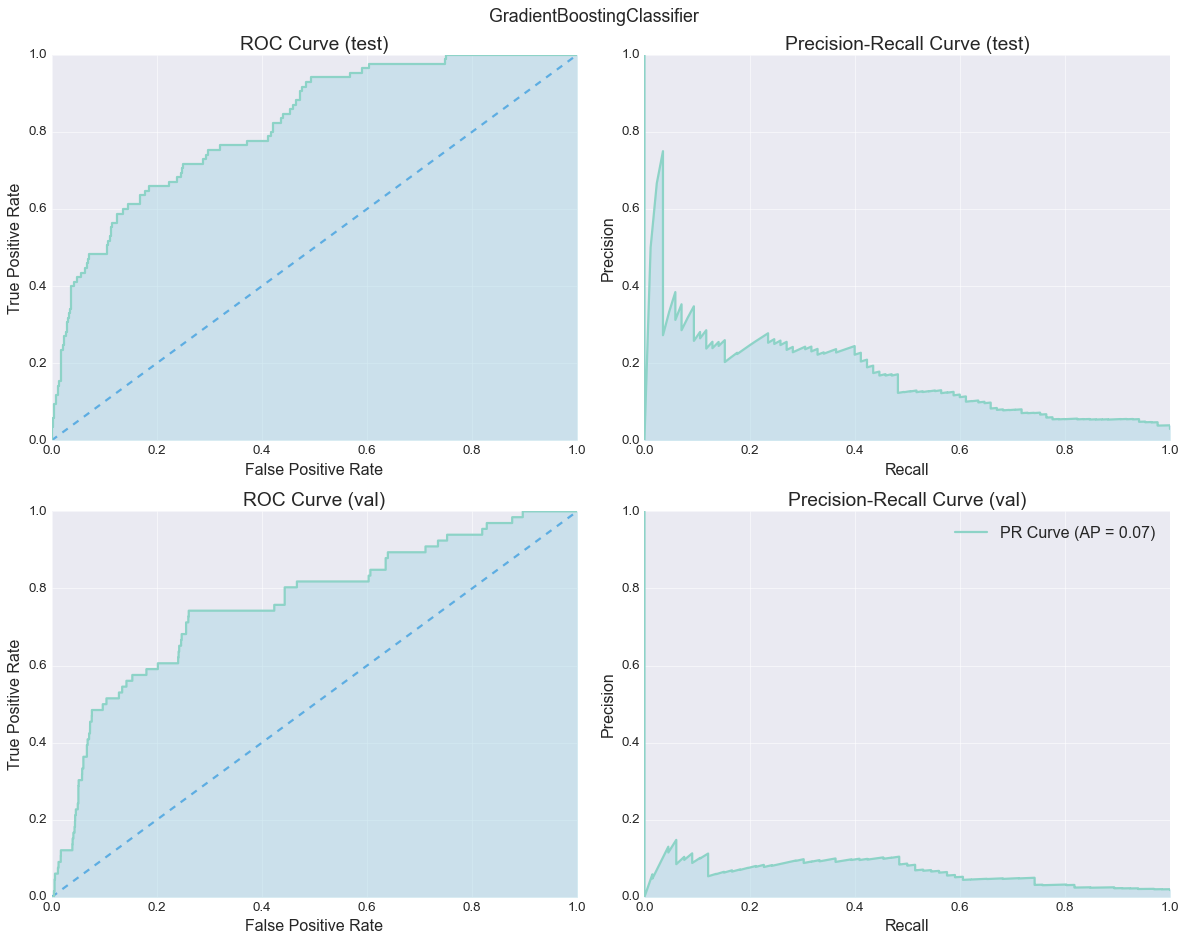

In [267]:
gbc = GradientBoostingClassifier(
    n_estimators=700,
    learning_rate=0.01,
    max_depth=3,
    min_samples_split=9,
    min_samples_leaf=10,
    subsample=0.5,
    max_features='log2',
    loss='log_loss',
    random_state=42,
    n_iter_no_change=6,
    tol=1e-4
)
gbc.fit(X_train, y_train)

evaluate_model(gbc, X_test, y_test, X_valid, y_valid, 'GradientBoostingClassifier')

Ансамбль (стэккинг)

ROC-AUC on test data: 0.8390478205670757
Precision-Recall on test data: 0.18881096930956287
ROC-AUC on validation data: 0.7914887126296524
Precision-Recall on validation data: 0.16167246087451695


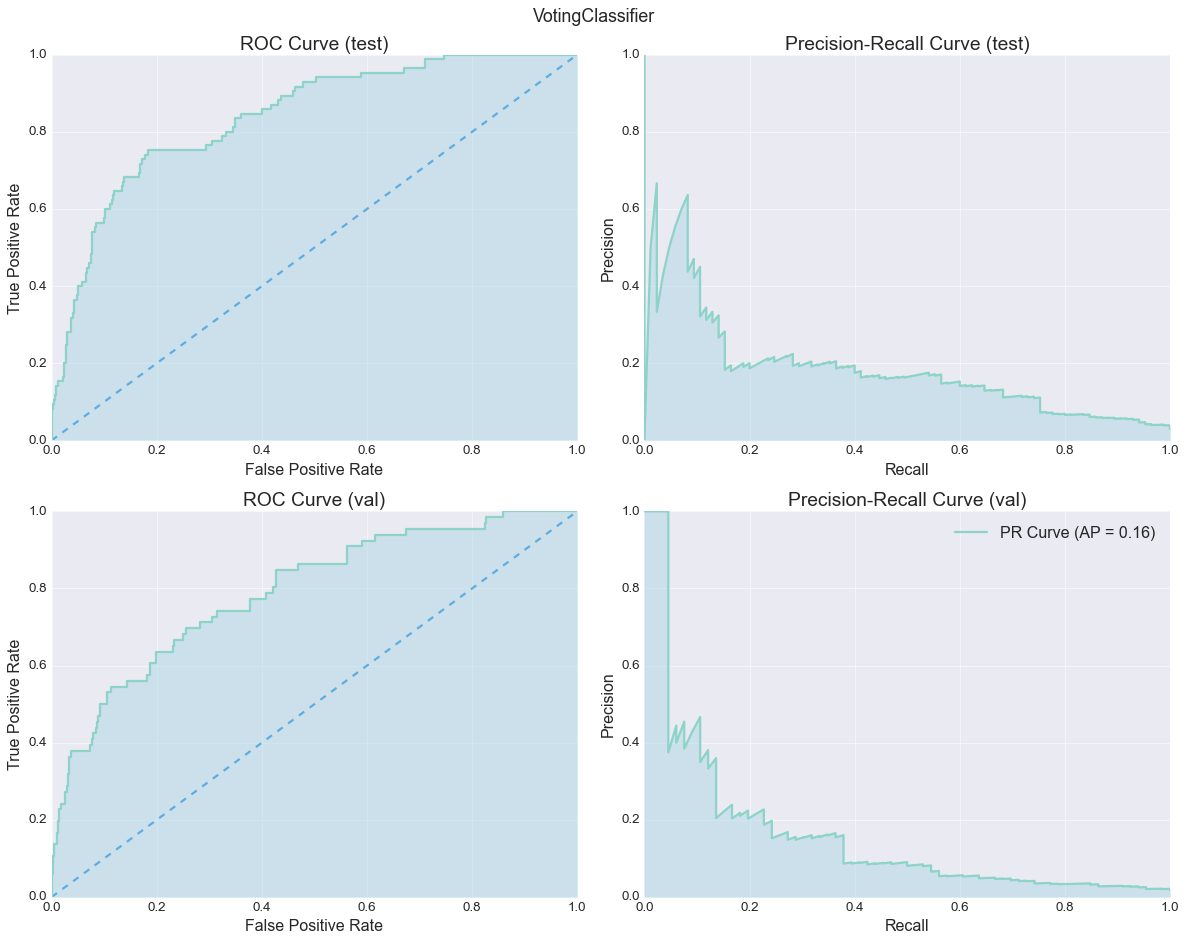

In [268]:
voting_model = VotingClassifier(
    estimators=[
        ('hgbc', hgbc),
        ('rfc', rfc),
        ('gbc', gbc)
    ],
    voting='soft'  # Используем усреднение вероятностей
)

# Обучаем ансамбль
voting_model.fit(X_train, y_train)

evaluate_model(voting_model, X_test, y_test, X_valid, y_valid, 'VotingClassifier')

In [ ]:
y_pred_valid = voting_model.predict(X_valid)
y_pred_proba_valid = voting_model.predict_proba(X_valid)[:,1]

results_df = pd.DataFrame({
    'target': y_valid,  # Истинные значения
    'prediction': y_pred_valid,  # Предсказанные классы
    'probability': y_pred_proba_valid  # Вероятности для класса 1
})
print(results_df.head())
roc_auc = roc_auc_score(y_valid, y_pred_proba_valid)
results_df.to_csv('res.csv', index=False)

   target  prediction  probability
0     0.0         0.0     0.020429
1     0.0         0.0     0.020092
2     0.0         0.0     0.073151
3     0.0         0.0     0.231567
4     0.0         0.0     0.010523


In [270]:
results_df[results_df['prediction']==1.0]

,target,prediction,probability
756,1.0,1.0,0.523652
1489,1.0,1.0,0.526428
1490,1.0,1.0,0.530269
1515,0.0,1.0,0.513962
2810,0.0,1.0,0.515508
3171,0.0,1.0,0.520253
3281,0.0,1.0,0.507578
